In [10]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *
"""
# Get 99% thickness
def get_L99(y,utilde):
    utilde = np.squeeze(utilde)
    du = abs(utilde[-1]-utilde[0])
    utop = 0.99*du/2.
    ubot = -0.99*du/2.
    Ny = np.size(y)
    ibot = np.argmin(abs(utilde[Ny/2:]-utop)[::-1])
    itop = np.argmin(abs(utilde[:Ny/2]-ubot)[::-1])+Ny/2
    #itop = np.argmin(abs(utilde[Ny/2:]-utop))+Ny/2
    #ibot = np.argmin(abs(utilde[:Ny/2]-ubot))
    L99 = y[itop]-y[ibot]
    if L99<0: print('utilde or y misoriented. exiting'); sys.exit()
    return L99, itop, ibot
"""
def get_lscale_vs_t(directory,flist):
    mat = np.zeros([len(flist),4])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta

        # Get y lengthscale
        autocorr = np.fromfile(fname,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0]
        ly = get_lscale(y,autocorr,thresh=0.25)
        
        # Get xz lengthscale (vv only)
        if inp.rr==1:
            #hf =  h5py.File(directory+'/autocorr_%04d.h5'%tID,'r')
            fname=fname.replace('lscale','autocorr').replace('dat','h5')
            hf =  h5py.File(fname,'r')
            autocorr = np.mean(hf['qx'],axis=-1)
            autocorr = np.fft.fftshift(autocorr)
            lx = get_lscale(x,autocorr,thresh=0.2)
            autocorr = np.mean(hf['qz'],axis=0)
            autocorr = np.fft.fftshift(autocorr)
            lz = get_lscale(z,autocorr)
        else:
            lx = 0
            lz = 0

        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID, sep=' ')
        L99,i1,i2 = get_L99(y,utilde)
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = ly/L99
        mat[i,2] = lx/ly
        mat[i,3] = lz/ly
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

directory = '/home/kmatsuno/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_pp*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 1.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 100.0x100.0x50.0
['lscale_pp_0001.dat', 'lscale_pp_0002.dat', 'lscale_pp_0003.dat', 'lscale_pp_0004.dat', 'lscale_pp_0005.dat', 'lscale_pp_0006.dat', 'lscale_pp_0007.dat', 'lscale_pp_0008.dat', 'lscale_pp_0009.dat', 'lscale_pp_0010.dat', 'lscale_pp_0011.dat', 'lscale_pp_0012.dat']


In [9]:
flist = glob.glob(directory+"*lscale_vv*")
dat = get_lscale_vs_t(directory,flist[0:])
plt.plot(dat[:,0],dat[:,2],'-*')
plt.grid(True)

idx = 5
ie = 10
for j in [1,2,3]:
    print('{}:[{},{}],'.format(inp.Mc,np.mean(dat[idx:ie,j]),np.std(dat[idx:ie,j])))


IOError: Unable to open file (unable to open file: name = '/home/kmatsuno/ShearLayerData/production/Mc12/rr1/1024x1448x512/autocorr_vv_0011.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

0.2:[0.225855864334,0.00569150796454],
0.4:[0.253589896948,0.0231448185755],
0.8:[0.12273853121,0.00447437551297],
1.2:[0.0992630966748,0.00330202321737],
1.6:[0.098520497714,0.00618381392433],
2.0:[0.0789554789969,0.00340818448338],
Done


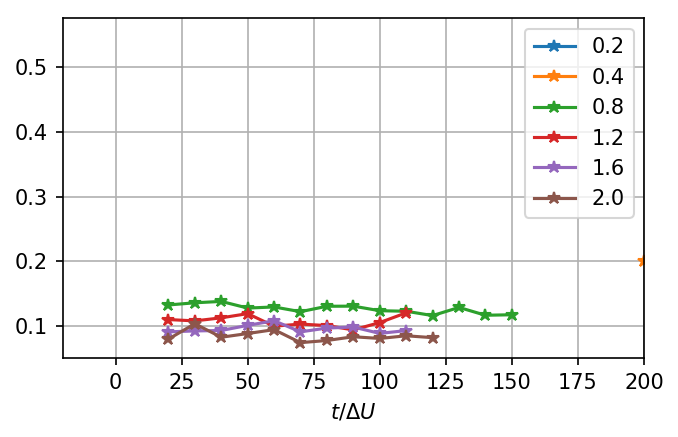

In [108]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    lscale = 'vv'
    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'
    flist = glob.glob(dir_out+"*lscale_%s*"%lscale)
    flist.sort()
    
    dat = get_lscale_vs_t(directory,flist[1:-1])
    t = dat[:,0]
    f = dat[:,1] # 1:ly/l9, 2:lx/ly, 3:lz/ly
    ax.plot(t,f,'-*',label='{}'.format(inp.Mc))

    ist = -6
    ie = -2
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ie]),np.std(f[ist:ie])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')
ax.set_xlim([-20,200]);
# plt.ylim([0,1.])
# savename='/home/kmatsuno/ShearLayer_img/vs_t/lscale_%s_s%s'%(lscale,s)
# print(savename)
# fig.savefig(savename,dpi=200, bbox_inches='tight')

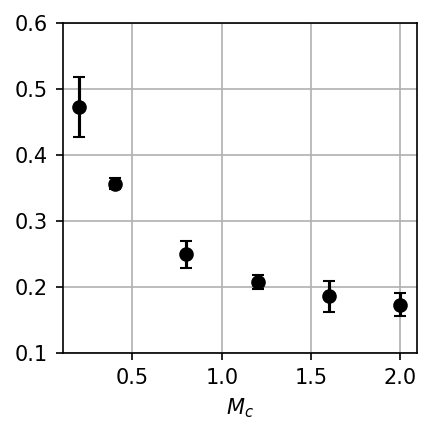

In [6]:
vv = ly
vv_7 = {
0.2:[0.330201801034,0.00637322462226],
0.8:[0.254559849028,0.0114950356107],
2.0:[0.17024371122,0.0516906200322],
}
pp = {
0.2:[0.845815817682,0.00796988668202],
0.4:[0.698487404408,0.11072240257],
0.8:[0.601662039403,0.0446973253622],
1.2:[0.345029305599,0.0902128854104],
1.6:[0.246203610228,0.0977139845744],
2.0:[0.192412810687,0.0600864472128],
}
pp_7 = {
0.2:[0.699530570789,0.0401965350737],
0.8:[0.470592519587,0.0600051817717],
2.0:[0.237014985854,0.0295487843553],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

    
name = 'vv'
    
fig = plt.figure(figsize=(3,3),dpi=150)
if name=='vv':
    s1 = vv
    s7 = vv_7
elif name=='pp':
    s1 = pp
    s7 = pp_7
plotter(s1,'s=1','ko')
# plotter(s7,'s=7','o')

plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$L/L_{99}$')
# plt.legend(fontsize=8)
# plt.xlim([0,2.2])
plt.ylim([0.1,0.6])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/lscale_%s.png'%name,dpi=200, bbox_inches='tight')